In [1]:
# Force automatic reload of external functions
# see http://ipython.org/ipython-doc/stable/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

import pandas as pd
import pickle
import matplotlib.pyplot as plt
from IPython import display as dis
%matplotlib inline

%aimport -pd
%aimport -pickle
%aimport -plt
%aimport -dis

# import numpy as np
# import networkx as nx

In [2]:
# %load https://gist.github.com/ajp619/ddaa0f35627b066ef528/raw/cbbd6c6c1cad286ba5a358b93fd94eddede7c4ba/qtutil.py
# silly utility to launch a qtconsole if one doesn't exist

consoleFlag = True
consoleFlag = False  # Turn on/off by commenting/uncommenting this line

import psutil

def returnPyIDs():
    pyids = set()
    for pid in psutil.pids():
        try:
            if "python" in psutil.Process(pid).name():
                pyids.add(pid)
        except:
            pass
    return pyids

def launchConsole():
    before_pyids = returnPyIDs()
    %qtconsole
    after_pyids = returnPyIDs()
    newid = after_pyids.difference(before_pyids)
    assert len(newid) == 1
    return list(newid)[0]

try:
    print qtid
except NameError:
    if consoleFlag:
        qtid = launchConsole()
        print qtid
    
if consoleFlag and (qtid not in returnPyIDs()):
    qtid = launchConsole()
    print qtid

In [3]:
graphs = pickle.load( open("make_graphs.p", "rb" ) )
seasons = pickle.load( open("wiki_scrape.p", "rb" ) )
voteweights = pickle.load( open("process_votes.p", "rb" ) )

In [4]:
# Season numbering

snums = pd.DataFrame({'season': seasons.keys(),
                      'season_num': [seasons[i]['num'] 
                                     for i in seasons.keys()]})

snums

,season,season_num
0,Palau,10
1,Tocantins,18
2,Borneo,1
3,Panama,12
4,Cambodia,31
5,Blood_vs._Water,27
6,Marquesas,4
7,Pearl_Islands,7
8,Vanuatu,9
9,The_Australian_Outback,2


### Calculate centrality measures

In [5]:
%%writefile network.py

import pandas as pd
import numpy as np
import networkx as nx
import pickle

# Build pandas df of all centrality scores
# Degree, closeness, betweenness, eigenvector, pagerank

def centrality_scores(vote_matrix, season_graph):
    deg = nx.degree(season_graph)
    deg = {k: round(v,1) for k,v in deg.iteritems()}

    close = nx.closeness_centrality(season_graph)
    close = {k: round(v,3) for k,v in close.iteritems()}

    btw = nx.betweenness_centrality(season_graph)
    btw = {k: round(v,3) for k,v in btw.iteritems()}

    eig = nx.eigenvector_centrality_numpy(season_graph)
    eig = {k: round(v,3) for k,v in eig.iteritems()}
    
    page = nx.pagerank(season_graph)
    page = {k: round(v,3) for k,v in page.iteritems()}

    # Add contestant placement (rank)
    order = list(vote_matrix.index)
    place_num = list(range(len(order)))
    place = {order[i]:i+1 for i in place_num}
    
    names = season_graph.nodes()

    # Build a table with centralities 
    table=[[name, deg[name], close[name], btw[name], eig[name], page[name], place[name]] for name in names]

    # Convert table to pandas df
    headers = ['name', 'deg', 'close', 'btw', 'eig', 'page', 'place']
    df = pd.DataFrame(table, columns=headers)
    df = df.sort(['page', 'eig', 'deg'], ascending=[0, 0, 0])
    
    return df

def distance_scores(season, graph):
    
    # Take largest connected component
    g = graph if nx.is_connected(graph) else max(nx.connected_component_subgraphs(graph), key=len)
    
    # Ratio of largest connected component subgraph
    conn = len(max(nx.connected_component_subgraphs(g), key=len)) / float(nx.number_of_nodes(graph))
    conn = np.round(conn, 3)
    
    # Radius, diameter
    rad = nx.radius(g)
    diam = nx.diameter(g)
    
    # Average eccentricity
    ecc = np.mean(nx.eccentricity(g).values())
    ecc = np.round(ecc, 3)
    
    # Put it all into a dataframe
    df = pd.DataFrame([[season,conn,rad,diam,ecc]], columns=['season', 'conn', 'rad', 'diam', 'ecc'])
    
    return df

def get_all_centrality_scores(voteweights, graphs, save_to_disk=True):
    central = {s: centrality_scores(voteweights[s], graphs[s]) 
               for s in graphs.keys()}
    if save_to_disk:
        pickle.dump( central, open( "network.p", "wb" ) )
    return central

Overwriting network.py


In [6]:
from network import *

central = get_all_centrality_scores(
    voteweights, graphs, save_to_disk=True
)

network.py:39: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  df = df.sort(['page', 'eig', 'deg'], ascending=[0, 0, 0])


In [7]:
graphs.keys()

[u'Palau',
 u'Tocantins',
 u'Borneo',
 u'Panama',
 u'Cambodia',
 u'Blood_vs._Water',
 u'Marquesas',
 u'Pearl_Islands',
 u'Vanuatu',
 u'The_Australian_Outback',
 u'Heroes_vs_Villains',
 u'Guatemala',
 u'China',
 u'Worlds_Apart',
 u'Thailand',
 u'The_Amazon',
 u'Cagayan',
 u'South_Pacific',
 u'One_World',
 u'Philippines',
 u'Caramoan',
 u'Gabon',
 u'Micronesia',
 u'Samoa',
 u'All-Stars',
 u'Nicaragua',
 u'Africa',
 u'San_Juan_del_Sur',
 u'Cook_Islands',
 u'Redemption_Island',
 u'Fiji']

In [8]:
# Borneo example
s = graphs.keys()[2]
centrality_scores(voteweights[s], graphs[s])

,name,deg,close,btw,eig,page,place
14,Rudy,6,0.600,0.026,0.507,0.108,3
4,Susan,6,0.600,0.026,0.493,0.105,4
2,Richard,6,0.600,0.026,0.469,0.095,1
5,Kelly,8,0.652,0.271,0.354,0.093,2
13,Colleen,7,0.625,0.095,0.034,0.090,6
8,Jenna,11,0.789,0.405,0.093,0.087,8
11,Sean,6,0.600,0.026,0.359,0.074,5
0,Gervase,6,0.556,0.010,0.015,0.067,7
12,Gretchen,6,0.556,0.010,0.017,0.061,10
6,Joel,5,0.517,0.000,0.012,0.051,11


### Tabulate values for all seasons

In [9]:
for c in central.keys():
    print c
    dis.display(central[c])

Palau


,name,deg,close,btw,eig,page,place
8,Stephenie,13,0.724,0.426,0.162,0.098,7
15,Jenn,9,0.585,0.061,0.423,0.083,4
1,Ian,8,0.563,0.018,0.421,0.075,3
13,Tom,8,0.563,0.018,0.406,0.072,1
19,Katie,8,0.563,0.018,0.406,0.072,2
4,James,7,0.507,0.005,0.070,0.072,12
2,Gregg,9,0.585,0.061,0.350,0.070,6
17,Angie,7,0.507,0.005,0.065,0.066,13
18,Caryn,8,0.563,0.018,0.343,0.062,5
10,Bobby Jon,7,0.507,0.048,0.058,0.061,10


Tocantins


,name,deg,close,btw,eig,page,place
11,Stephen,10,0.704,0.074,0.478,0.120,2
2,J.T.,11,0.751,0.122,0.449,0.113,1
14,Taj,10,0.704,0.074,0.390,0.093,4
10,Erinn,9,0.663,0.035,0.327,0.091,3
1,Coach,9,0.663,0.035,0.236,0.078,5
8,Debbie,9,0.663,0.035,0.219,0.075,6
7,Sierra,9,0.663,0.035,0.197,0.068,7
12,Tyson,7,0.593,0.010,0.159,0.062,8
6,Joe,6,0.512,0.000,0.221,0.061,10
9,Sydney,6,0.512,0.000,0.221,0.061,11


Borneo


,name,deg,close,btw,eig,page,place
14,Rudy,6,0.600,0.026,0.507,0.108,3
4,Susan,6,0.600,0.026,0.493,0.105,4
2,Richard,6,0.600,0.026,0.469,0.095,1
5,Kelly,8,0.652,0.271,0.354,0.093,2
13,Colleen,7,0.625,0.095,0.034,0.090,6
8,Jenna,11,0.789,0.405,0.093,0.087,8
11,Sean,6,0.600,0.026,0.359,0.074,5
0,Gervase,6,0.556,0.010,0.015,0.067,7
12,Gretchen,6,0.556,0.010,0.017,0.061,10
6,Joel,5,0.517,0.000,0.012,0.051,11


Panama


,name,deg,close,btw,eig,page,place
15,Cirie,7,0.544,0.130,0.435,0.101,4
10,Danielle,7,0.594,0.117,0.464,0.099,2
8,Terry,7,0.622,0.300,0.053,0.099,3
0,Aras,6,0.467,0.009,0.451,0.095,1
12,Courtney,7,0.594,0.117,0.396,0.085,6
3,Austin,5,0.484,0.023,0.019,0.085,9
5,Shane,6,0.467,0.009,0.358,0.074,5
9,Nick,5,0.484,0.023,0.017,0.074,10
14,Sally,4,0.436,0.124,0.014,0.069,8
13,Bruce,5,0.451,0.000,0.300,0.059,7


Cambodia


,name,deg,close,btw,eig,page,place
18,Spencer,17,0.905,0.204,0.414,0.117,5
16,Abi-Maria,16,0.864,0.116,0.321,0.091,7
3,Tasha,12,0.731,0.014,0.370,0.085,6
13,Kelley,13,0.760,0.052,0.333,0.084,3
5,Kimmi,10,0.679,0.002,0.340,0.072,4
1,Jeremy,11,0.704,0.011,0.325,0.071,1
4,Keith,10,0.679,0.002,0.293,0.064,2
9,Kelly,13,0.760,0.090,0.154,0.055,11
15,Stephen,11,0.704,0.011,0.240,0.054,9
6,Andrew,12,0.731,0.014,0.177,0.049,12


Blood_vs._Water


,name,deg,close,btw,eig,page,place
1,Gervase,19,1.000,0.015,0.364,0.080,3
14,Tyson,19,1.000,0.015,0.354,0.080,1
0,Monica,19,1.000,0.015,0.352,0.079,2
9,Hayden,17,0.905,0.001,0.260,0.065,7
12,Tina,19,1.000,0.015,0.272,0.064,4
7,Caleb,17,0.905,0.001,0.255,0.064,9
3,Laura M.,19,1.000,0.015,0.270,0.062,6
10,Ciera,17,0.905,0.001,0.246,0.061,5
4,Aras,19,1.000,0.015,0.249,0.059,11
13,Kat,19,1.000,0.015,0.233,0.056,14


Marquesas


,name,deg,close,btw,eig,page,place
11,Vecepia,10,0.704,0.028,0.438,0.120,1
4,Sean,10,0.704,0.028,0.389,0.104,5
9,Paschal,9,0.663,0.015,0.412,0.098,4
15,Neleh,9,0.663,0.015,0.412,0.098,2
1,Kathy,8,0.626,0.011,0.366,0.082,3
6,Robert,9,0.663,0.006,0.221,0.067,6
12,Tammy,9,0.663,0.006,0.221,0.067,7
14,Rob,10,0.704,0.122,0.142,0.066,10
3,Zoe,9,0.663,0.006,0.194,0.056,8
7,Gina,7,0.593,0.071,0.053,0.050,11


Pearl_Islands


,name,deg,close,btw,eig,page,place
14,Jon,9,0.688,0.024,0.437,0.109,3
10,Sandra,9,0.688,0.024,0.418,0.100,1
6,Lillian,11,0.769,0.068,0.364,0.098,2
5,Christa,9,0.688,0.024,0.387,0.093,6
13,Darrah,11,0.769,0.068,0.264,0.092,4
15,Tijuana,11,0.769,0.068,0.209,0.079,7
11,Burton,8,0.653,0.033,0.307,0.074,5
12,Rupert,9,0.688,0.024,0.297,0.070,8
4,Andrew,6,0.568,0.000,0.078,0.048,10
9,Ryan O.,6,0.568,0.000,0.078,0.048,9


Vanuatu


,name,deg,close,btw,eig,page,place
9,Chris,11,0.739,0.136,0.282,0.091,1
10,Scout,8,0.586,0.003,0.422,0.088,3
14,Twila,9,0.607,0.021,0.404,0.084,2
6,Eliza,9,0.607,0.032,0.390,0.083,4
0,Ami,8,0.586,0.003,0.375,0.077,6
13,Leann,8,0.586,0.003,0.368,0.075,7
8,Julie,11,0.654,0.134,0.284,0.071,5
12,Rory,10,0.708,0.152,0.157,0.065,10
3,Chad,7,0.630,0.042,0.117,0.059,8
1,Lea,7,0.630,0.042,0.109,0.057,9


The_Australian_Outback


,name,deg,close,btw,eig,page,place
12,Tina,9,0.663,0.072,0.472,0.106,1
10,Colby,10,0.704,0.127,0.434,0.096,2
14,Keith,9,0.663,0.072,0.432,0.096,3
2,Rodger,9,0.663,0.065,0.206,0.094,5
8,Elisabeth,9,0.663,0.065,0.206,0.094,4
0,Amber,6,0.490,0.000,0.365,0.081,6
9,Nick,9,0.663,0.065,0.163,0.081,7
15,Jerri,6,0.490,0.000,0.318,0.072,8
5,Alicia,6,0.469,0.000,0.112,0.069,9
3,Jeff,7,0.593,0.019,0.090,0.055,10


Heroes_vs_Villains


,name,deg,close,btw,eig,page,place
3,Russell,11,0.661,0.064,0.440,0.082,3
18,Jerri,11,0.661,0.064,0.410,0.081,4
0,Sandra,11,0.661,0.064,0.412,0.079,1
2,Parvati,9,0.608,0.017,0.436,0.078,2
11,Rupert,11,0.661,0.073,0.161,0.075,6
15,Candice,13,0.724,0.175,0.165,0.071,8
13,Colby,11,0.661,0.073,0.144,0.066,5
8,Danielle,9,0.608,0.017,0.357,0.064,7
17,Amanda,8,0.507,0.000,0.101,0.063,9
4,J.T.,8,0.507,0.000,0.092,0.059,10


Guatemala


,name,deg,close,btw,eig,page,place
0,Stephenie,10,0.662,0.014,0.440,0.101,2
5,Rafe,10,0.662,0.014,0.440,0.101,3
12,Lydia,10,0.662,0.014,0.425,0.097,4
11,Danni,13,0.779,0.068,0.271,0.089,1
13,Cindy,12,0.735,0.057,0.284,0.077,5
16,Judd,11,0.697,0.050,0.285,0.072,6
14,Gary,11,0.697,0.029,0.211,0.072,7
2,Jamie,9,0.630,0.011,0.300,0.070,8
10,Bobby Jon,10,0.662,0.034,0.105,0.056,9
17,Amy,10,0.662,0.025,0.144,0.050,11


China


,name,deg,close,btw,eig,page,place
4,Todd,9,0.653,0.017,0.446,0.108,1
9,Amanda,9,0.653,0.017,0.446,0.108,3
10,Erik,11,0.769,0.086,0.255,0.096,6
11,Courtney,10,0.688,0.138,0.374,0.095,2
6,Denise,9,0.653,0.017,0.384,0.092,4
2,Frosti,11,0.769,0.086,0.257,0.086,8
0,Peih-Gee,11,0.769,0.086,0.210,0.085,5
3,James,9,0.653,0.017,0.259,0.066,7
8,Jaime,5,0.523,0.000,0.123,0.060,10
15,Jean-Robert,9,0.653,0.017,0.205,0.055,9


Worlds_Apart


,name,deg,close,btw,eig,page,place
3,Carolyn,13,0.773,0.046,0.390,0.098,2
0,Will,13,0.773,0.046,0.379,0.095,3
10,Tyler,13,0.773,0.046,0.335,0.083,7
15,Rodney,10,0.630,0.069,0.314,0.074,4
14,Sierra,10,0.607,0.054,0.281,0.069,5
17,Shirin,12,0.739,0.040,0.248,0.069,8
8,Hali,10,0.680,0.226,0.193,0.068,11
6,Dan,9,0.586,0.003,0.296,0.067,6
1,Mike,9,0.586,0.003,0.295,0.065,1
13,Jenn,9,0.630,0.006,0.207,0.061,9


Thailand


,name,deg,close,btw,eig,page,place
7,Brian,6,0.403,0.005,0.489,0.090,1
6,Jan,6,0.403,0.005,0.451,0.085,3
2,Clay,7,0.538,0.290,0.448,0.085,2
3,Ted,6,0.403,0.005,0.414,0.076,5
9,Penny,5,0.475,0.267,0.030,0.075,7
14,Stephanie,2,0.133,0.000,0.000,0.073,12
15,Robb,2,0.133,0.000,0.000,0.073,11
0,Ken,4,0.336,0.000,0.014,0.072,8
1,Jake,4,0.336,0.000,0.014,0.072,6
11,Helen,4,0.367,0.000,0.407,0.068,4


The_Amazon


,name,deg,close,btw,eig,page,place
6,Matthew,11,0.726,0.240,0.409,0.123,2
4,Rob,9,0.653,0.011,0.428,0.115,3
14,Jenna,9,0.688,0.041,0.397,0.110,1
11,Heidi,11,0.769,0.100,0.361,0.105,5
1,Butch,9,0.653,0.011,0.317,0.094,4
2,Alex,10,0.688,0.035,0.316,0.089,7
13,Deena,9,0.688,0.041,0.265,0.078,8
12,Christy,8,0.653,0.028,0.248,0.071,6
9,Roger,6,0.568,0.000,0.127,0.045,10
15,Jeanne,6,0.544,0.126,0.044,0.038,12


Cagayan


,name,deg,close,btw,eig,page,place
10,Woo,10,0.680,0.240,0.424,0.108,2
9,Tony,8,0.630,0.019,0.449,0.101,1
7,Kass,12,0.773,0.240,0.368,0.101,3
16,Spencer,9,0.680,0.090,0.198,0.091,4
4,Tasha,9,0.680,0.090,0.176,0.086,6
1,Jefra,7,0.607,0.070,0.376,0.084,7
2,Trish,5,0.548,0.000,0.396,0.081,5
3,Jeremiah,9,0.680,0.047,0.140,0.064,8
6,LJ,6,0.567,0.001,0.294,0.063,9
14,Morgan,7,0.586,0.137,0.065,0.057,10


South_Pacific


,name,deg,close,btw,eig,page,place
8,Cochran,13,0.739,0.056,0.257,0.085,8
1,Coach,9,0.630,0.005,0.418,0.082,2
6,Albert,9,0.630,0.005,0.403,0.081,3
12,Sophie,9,0.630,0.005,0.406,0.080,1
7,Brandon,9,0.630,0.005,0.387,0.077,6
9,Rick,11,0.680,0.031,0.363,0.073,5
11,Dawn,13,0.739,0.056,0.111,0.069,10
3,Edna,10,0.654,0.015,0.330,0.067,7
17,Whitney,13,0.739,0.056,0.106,0.066,9
0,Ozzy,9,0.630,0.012,0.068,0.058,4


One_World


,name,deg,close,btw,eig,page,place
11,Tarzan,13,0.769,0.032,0.298,0.094,6
17,Sabrina,10,0.641,0.002,0.400,0.093,2
14,Kim,10,0.641,0.002,0.406,0.092,1
4,Chelsea,10,0.641,0.002,0.386,0.088,3
6,Alicia,12,0.721,0.017,0.359,0.086,5
8,Christina,10,0.641,0.096,0.319,0.080,4
13,Troyzan,13,0.769,0.032,0.212,0.073,8
3,Jay,13,0.769,0.032,0.194,0.069,10
16,Leif,12,0.678,0.020,0.151,0.064,9
15,Kat,10,0.641,0.002,0.264,0.063,7


Philippines


,name,deg,close,btw,eig,page,place
10,Denise,11,0.678,0.145,0.522,0.154,1
7,Malcolm,10,0.641,0.108,0.454,0.122,4
9,Michael,8,0.576,0.027,0.404,0.093,3
12,Lisa,6,0.501,0.015,0.373,0.090,2
17,Carter,9,0.607,0.039,0.241,0.084,6
14,Jonathan,8,0.576,0.105,0.191,0.073,7
13,Abi-Maria,8,0.576,0.027,0.229,0.069,5
5,Jeff,7,0.549,0.031,0.148,0.056,10
0,Pete,6,0.443,0.006,0.103,0.047,8
2,Artis,6,0.443,0.006,0.095,0.043,9


Caramoan


,name,deg,close,btw,eig,page,place
7,Sherri,13,0.760,0.104,0.345,0.089,3
16,Dawn,10,0.679,0.010,0.439,0.087,2
18,Cochran,10,0.679,0.013,0.410,0.081,1
6,Brenda,11,0.704,0.084,0.343,0.073,6
13,Erik,12,0.731,0.113,0.309,0.070,5
11,Eddie,15,0.826,0.171,0.129,0.066,4
15,Andrea,10,0.679,0.007,0.316,0.064,7
5,Phillip,9,0.613,0.011,0.307,0.060,10
2,Michael,10,0.633,0.039,0.096,0.058,11
19,Reynold,11,0.704,0.078,0.088,0.054,8


Gabon


,name,deg,close,btw,eig,page,place
8,Matty,11,0.717,0.040,0.452,0.112,4
10,Crystal,10,0.684,0.029,0.444,0.105,6
1,Ken,12,0.753,0.055,0.421,0.103,5
3,Susie,11,0.684,0.039,0.377,0.090,2
9,Sugar,11,0.717,0.062,0.358,0.090,3
15,Bob,10,0.655,0.022,0.161,0.068,1
12,Randy,11,0.684,0.046,0.153,0.057,8
4,Ace,10,0.684,0.054,0.149,0.051,12
0,Corinne,9,0.627,0.015,0.085,0.049,7
16,G.C.,8,0.602,0.014,0.174,0.048,14


Micronesia


,name,deg,close,btw,eig,page,place
13,Cirie,14,0.741,0.053,0.460,0.110,3
17,Amanda,13,0.711,0.036,0.454,0.102,2
12,Erik,12,0.711,0.059,0.333,0.088,5
0,Ozzy,13,0.711,0.036,0.375,0.085,9
4,Parvati,12,0.682,0.032,0.323,0.074,1
3,Natalie,12,0.711,0.074,0.220,0.071,4
10,Alexis,12,0.682,0.097,0.172,0.059,6
7,James,11,0.656,0.019,0.225,0.053,7
1,Ami,11,0.632,0.023,0.210,0.049,11
2,Chet,10,0.656,0.035,0.102,0.044,14


Samoa


,name,deg,close,btw,eig,page,place
12,Mick,15,0.826,0.243,0.433,0.108,3
5,Russell H.,14,0.792,0.066,0.452,0.106,2
2,Natalie,14,0.792,0.066,0.436,0.102,1
9,Jaison,14,0.792,0.066,0.420,0.099,5
7,Brett,12,0.731,0.020,0.257,0.077,4
0,Monica,12,0.731,0.020,0.203,0.067,7
11,Dave,12,0.731,0.020,0.159,0.057,8
16,John,12,0.731,0.020,0.136,0.052,9
6,Shambo,12,0.731,0.114,0.166,0.051,6
17,Laura,12,0.731,0.020,0.116,0.048,10


All-Stars


,name,deg,close,btw,eig,page,place
1,Amber,9,0.576,0.065,0.449,0.108,1
13,Jenna L.,9,0.607,0.076,0.423,0.104,3
4,Rob M.,7,0.524,0.013,0.436,0.097,2
14,Shii Ann,11,0.678,0.114,0.239,0.096,6
6,Rupert,8,0.549,0.032,0.390,0.094,4
10,Tom,7,0.524,0.013,0.364,0.082,5
16,Jerri,8,0.549,0.051,0.104,0.067,10
11,Lex,6,0.524,0.011,0.086,0.062,9
0,Kathy,6,0.524,0.011,0.083,0.058,8
5,Alicia,7,0.524,0.013,0.231,0.055,7


Fiji


,name,deg,close,btw,eig,page,place
2,Yau-Man,11,0.658,0.089,0.375,0.101,4
14,Dreamz,10,0.595,0.036,0.403,0.099,3
0,Earl,10,0.625,0.061,0.373,0.090,1
8,Mookie,10,0.625,0.059,0.270,0.089,8
3,Alex,8,0.543,0.022,0.272,0.069,7
11,Stacy,8,0.543,0.018,0.307,0.068,6
6,Cassandra,6,0.500,0.002,0.307,0.062,2
9,Boo,8,0.543,0.018,0.273,0.060,5
5,Edgardo,7,0.521,0.015,0.209,0.056,9
18,Rocky,10,0.625,0.059,0.172,0.056,12


Africa


,name,deg,close,btw,eig,page,place
6,Kim J.,10,0.750,0.023,0.449,0.112,2
10,Ethan,10,0.750,0.023,0.449,0.112,1
13,Lex,10,0.750,0.023,0.408,0.099,3
12,Tom,11,0.789,0.179,0.347,0.095,4
15,Kim P.,10,0.750,0.076,0.268,0.093,6
3,Frank,11,0.789,0.111,0.228,0.078,7
5,Teresa,10,0.750,0.090,0.228,0.078,5
7,Brandon,9,0.714,0.059,0.201,0.070,8
8,Kelly,10,0.750,0.023,0.237,0.063,9
1,Clarence,7,0.577,0.006,0.156,0.043,10


San_Juan_del_Sur


,name,deg,close,btw,eig,page,place
10,Baylor,13,0.793,0.090,0.426,0.109,5
12,Jaclyn,13,0.793,0.157,0.405,0.108,2
11,Missy,10,0.684,0.067,0.387,0.092,3
17,Alec,12,0.753,0.063,0.300,0.092,7
1,Natalie,9,0.655,0.048,0.312,0.078,1
15,Keith,9,0.655,0.013,0.309,0.076,4
9,Wes,8,0.602,0.009,0.216,0.071,9
16,Jon,8,0.627,0.006,0.314,0.069,6
7,Josh,8,0.602,0.009,0.141,0.047,11
0,Dale,6,0.558,0.030,0.102,0.044,13


Cook_Islands


,name,deg,close,btw,eig,page,place
2,Parvati,13,0.741,0.057,0.310,0.088,6
7,Adam,13,0.741,0.057,0.310,0.088,5
15,Jonathan,12,0.711,0.112,0.341,0.080,7
0,Ozzy,10,0.632,0.064,0.350,0.079,2
1,Becky,9,0.609,0.035,0.356,0.076,3
11,Yul,9,0.609,0.035,0.356,0.076,1
9,Sundra,10,0.632,0.041,0.352,0.075,4
10,Candice,10,0.656,0.019,0.280,0.064,8
14,Jenny,9,0.632,0.012,0.195,0.063,10
18,Nate,10,0.656,0.127,0.170,0.061,9


Redemption_Island


,name,deg,close,btw,eig,page,place
1,Mike,8,0.654,0.066,0.038,0.086,6
11,Ralph,9,0.680,0.078,0.026,0.080,9
0,Steve,6,0.567,0.007,0.018,0.074,10
7,Rob,7,0.607,0.037,0.422,0.072,1
17,Julie,6,0.567,0.007,0.017,0.070,11
2,Natalie,5,0.459,0.000,0.436,0.069,3
14,Ashley,5,0.459,0.000,0.436,0.069,4
6,Phillip,6,0.586,0.022,0.421,0.069,2
5,Grant,8,0.654,0.067,0.377,0.068,8
10,Matthew,14,0.850,0.449,0.053,0.068,7


Nicaragua


,name,deg,close,btw,eig,page,place
15,Holly,16,0.853,0.057,0.387,0.095,4
8,Dan,16,0.853,0.057,0.334,0.087,5
19,Chase,12,0.711,0.008,0.372,0.080,2
17,Sash,12,0.711,0.006,0.347,0.077,3
16,NaOnka,12,0.711,0.008,0.295,0.065,9
2,Fabio,13,0.741,0.072,0.273,0.064,1
14,Jane,17,0.898,0.074,0.236,0.064,6
7,Benry,12,0.711,0.008,0.270,0.060,7
1,Marty,16,0.853,0.057,0.189,0.060,11
3,Kelly S.,12,0.711,0.006,0.223,0.052,8


### Winner table

In [10]:
# Test structure
borneo = central['Borneo']
borneo[borneo['place']==1]

,name,deg,close,btw,eig,page,place
2,Richard,6,0.6,0.026,0.469,0.095,1


In [11]:
# Create winners dataframe
winner_list = [central[i][central[i]['place']==1] for i in central.keys()]
winners = pd.concat(winner_list).reset_index(drop=True)

# Add season and season_num; Drop place (all 1)
winners['season'] = central.keys()
winners = winners.merge(snums)
winners.drop('place', 1, inplace=True)
winners = winners.sort(['season_num'])
winners

C:\Anaconda\envs\dato-env\lib\site-packages\IPython\kernel\__main__.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,name,deg,close,btw,eig,page,season,season_num
2,Richard,6,0.600,0.026,0.469,0.095,Borneo,1
9,Tina,9,0.663,0.072,0.472,0.106,The_Australian_Outback,2
26,Ethan,10,0.750,0.023,0.449,0.112,Africa,3
6,Vecepia,10,0.704,0.028,0.438,0.120,Marquesas,4
14,Brian,6,0.403,0.005,0.489,0.090,Thailand,5
15,Jenna,9,0.688,0.041,0.397,0.110,The_Amazon,6
7,Sandra,9,0.688,0.024,0.418,0.100,Pearl_Islands,7
24,Amber,9,0.576,0.065,0.449,0.108,All-Stars,8
8,Chris,11,0.739,0.136,0.282,0.091,Vanuatu,9
0,Tom,8,0.563,0.018,0.406,0.072,Palau,10


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000001AD63048>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000001B2B4240>], dtype=object)

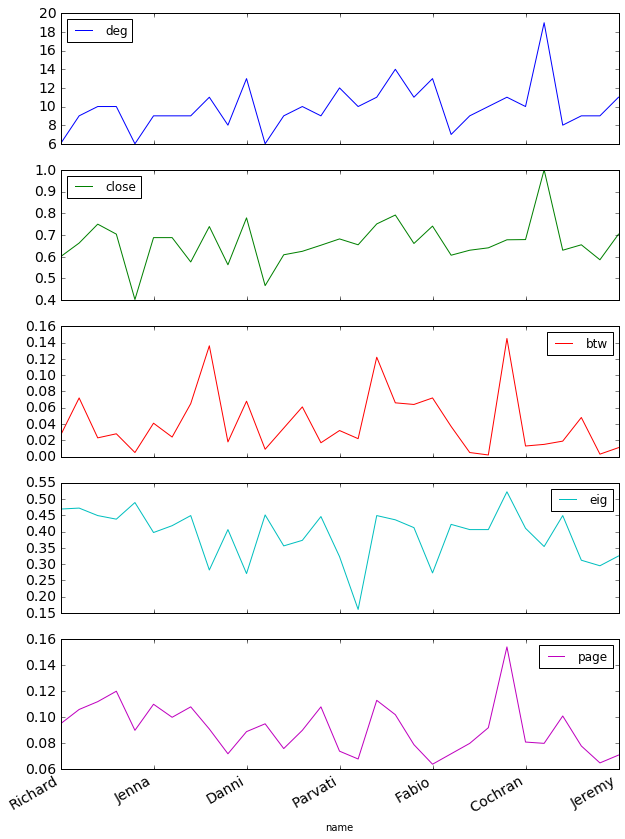

In [12]:
winners.plot(x="name", 
             y=['deg', 'close', 'btw', 'eig', 'page'], 
             subplots=True,
             figsize=(10,15),
             fontsize=14)

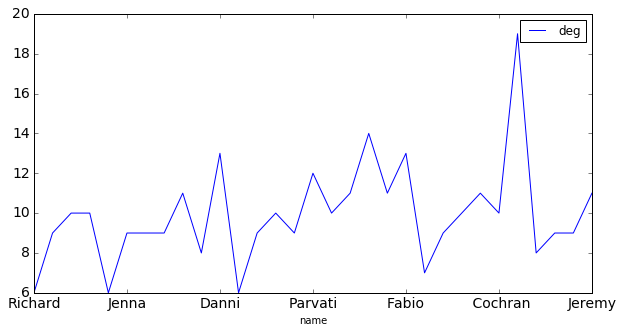

In [13]:
winners.plot(x="name", y='deg', figsize=(10,5), fontsize=14)

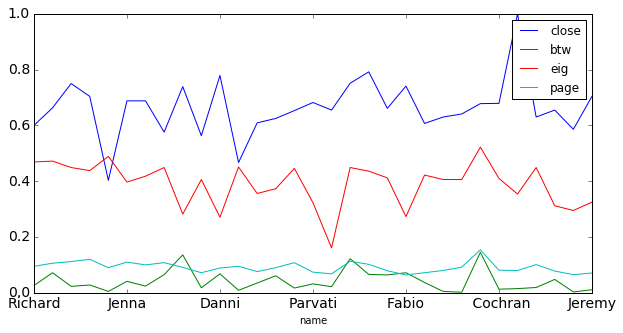

In [14]:
winners.plot(x="name", y=['close', 'btw', 'eig', 'page'],
            figsize=(10,5), fontsize=14)

### Network distance

In [15]:
d = [distance_scores(s, graphs[s]) for s in graphs.keys()]

In [16]:
distance = pd.concat(d)
distance = distance.merge(snums)
distance = distance.sort(['season_num'])
distance

C:\Anaconda\envs\dato-env\lib\site-packages\IPython\kernel\__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,season,conn,rad,diam,ecc,season_num
2,Borneo,1.000,2,4,3.188,1
9,The_Australian_Outback,0.875,2,3,2.500,2
26,Africa,1.000,2,3,2.438,3
6,Marquesas,0.875,2,2,2.000,4
14,Thailand,0.750,2,3,2.833,5
15,The_Amazon,0.938,2,4,2.933,6
7,Pearl_Islands,0.938,2,3,2.267,7
24,All-Stars,0.833,2,4,2.867,8
8,Vanuatu,1.000,2,4,3.056,9
0,Palau,0.900,2,4,3.167,10


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000001C0BAF28>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000001C641B70>], dtype=object)

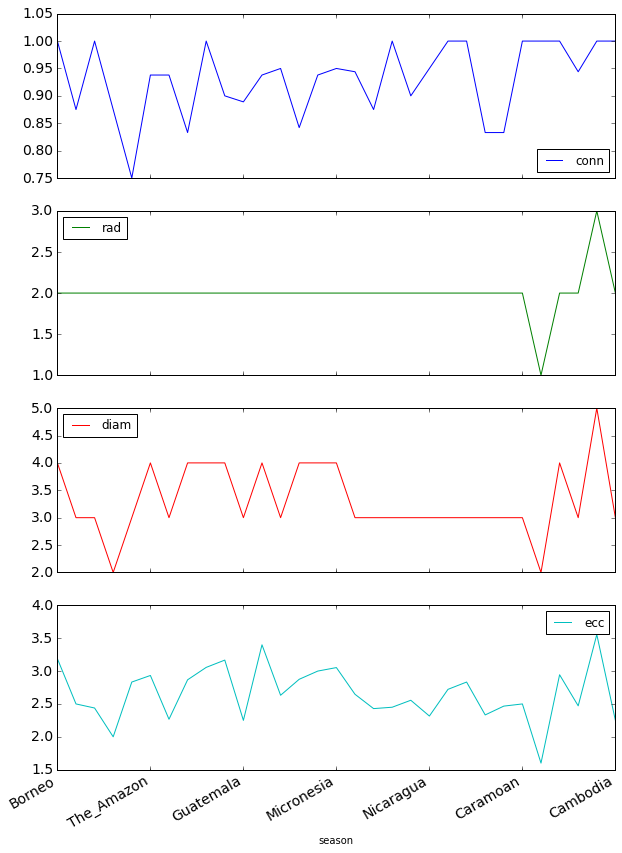

In [17]:
distance.plot(x="season", 
             y=['conn', 'rad', 'diam', 'ecc'], 
             subplots=True,
             figsize=(10,15),
             fontsize=14)

### Eyeballing the tables and graphs...
* No real changes in distance (presumably too small a network?)
* Slight upwards trend in winner degrees and closeness (more alliance shifting and/or game rules that mixes players more?)
* Slight downwards trend in eigenvalue and pagerank (winner less dominant?)
* Should do centrality averages for each season

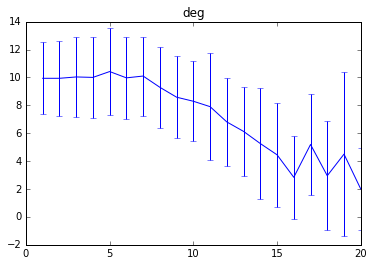

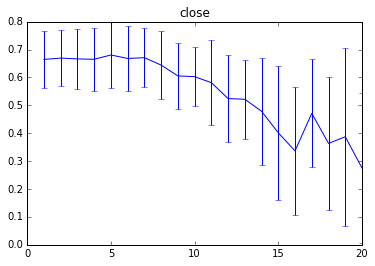

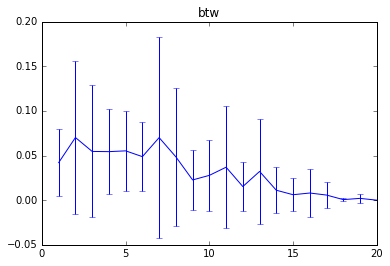

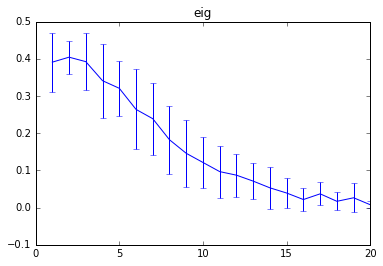

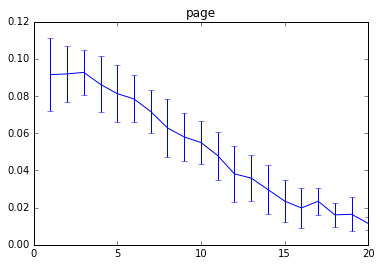

In [18]:
df = pd.DataFrame()
for i in central.keys():
    df = df.append(central[i])
    
grouped = df.groupby(['place'])
dfMean = grouped.mean()
dfStd = grouped.std()

for c in dfMean.columns:
    plt.errorbar(dfMean.index.values, dfMean[c].values, dfStd[c].values)
    plt.title(c)
    plt.show()

Other ideas:
* plot of these statistics over episodes (maybe normalized based on percentage of episodes completed) - this is applying the longitudinal concept to the season rather than across seasons.

Other features to explore:
* some measure of how badly you burned the jury memebers 
    - switching aliances ?
    - voting with people then suddenly voting against them?
    
Things to consider:
* It makes sense that the winners will have a higher degree than the losers - they've been in the game longer. Might be interesting to compare the average of these statistics over episodes and see early on if winners outpace the average somehow. i.e. in the middle of the show, how do we answer the question "who's going to win?"

